In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [27]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

First load the sst data. \
Since the temperature unit is in Kelvin, we want to convert it into Celsius by subtracting 273.15.

In [28]:
sst = ds['analysed_sst']-273.15

Define the monthly average sst in the previous years.

In [29]:
sst_previous = sst.sel(time=slice('2002', '2012')) # select the sst from year 2002 to 2012
sst_avg = sst_previous.groupby('time.month').mean('time') # take the average, group by month
sst_avg.shape

(12, 251, 234)

Define month and year for plotting (this will be used in a for loop).

In [30]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year = ["2014","2015","2016"]

Import the color needed for the plot.

In [31]:
from matplotlib import cm
import matplotlib.colors
color = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkblue","blue","cyan","white","yellow","red","darkred"])

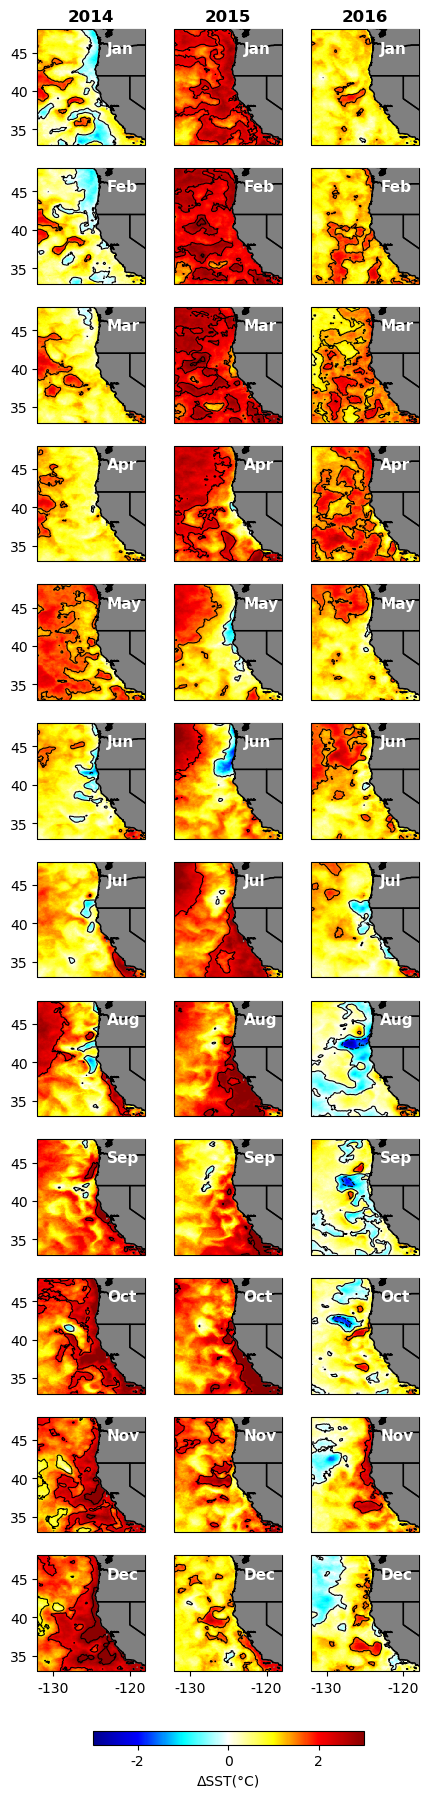

In [32]:
# set the figure for plot
fig, axs = plt.subplots(nrows=12, ncols=3, 
                        sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(5,26))

# create subplots for every month from 2014 to 2016
for y in range(len(year)):
    for m in range(len(month)):
        # prepare anomaly data for subplots
        temp_sst = sst.sel(time = (sst.time.dt.year==y+2014) & (sst.time.dt.month==m+1)).mean('time')
        temp_avg = sst_avg.sel(month = m+1)
        anomaly = temp_sst - temp_avg
        
     # plot subplots
        cmap = anomaly.plot(ax=axs[m, y], transform=crs, add_colorbar=False, cmap=color, vmin=-3, vmax=3, zorder=1) 
        anomaly.plot.contour(ax=axs[m, y], colors='black', levels = 5,linewidths=.8,zorder=2)
        
    # Plot overall titles and labels for the figure
        axs[m,y].add_feature(cfeature.LAND, color="grey", zorder=3)
        axs[m,y].add_feature(cfeature.STATES.with_scale("10m"), zorder=4)
        axs[m,y].set_title("") # this is to remove the default title
        axs[m,y].set(xlabel=None, ylabel=None) # this is to remove the default labels
        # Plot month name
        axs[m,y].text(-123, 45, month[m], fontsize=11, color="white", fontweight="semibold",zorder=5)
        # add year on the first row
        if m == 0:
            axs[m,y].set_title(year[y],fontsize=12, fontweight="bold")
        
        # add yticks for latitude on the left column
        if y == 0:
            axs[m,y].set_yticks([35, 40, 45])
            axs[m,y].set_yticklabels([35,40,45], fontsize=10)
            
        # add xticks for longitude on the bottom row
        if m == 11:
            axs[m,y].set_xticks([-130, -120])
            axs[m,y].set_xticklabels([-130, -120], fontsize=10)  
        
# plot the colorbar
cbar = plt.colorbar(cmap, ax=axs, location='bottom', shrink=0.7, pad=0.03)
cbar.set_label('ΔSST(°C)', loc="center")
cbar.set_ticks([-2, 0, 2])
cbar.set_ticklabels([-2, 0, 2])

plt.show()